# Krylov methods CG and GMRES

We study the paper [Towards understanding CG and GMRES through
examples](#cls2024).    The following text is partly or completely taken from this article.

All presented algorithms and examples are implemented in Python.

We want to solve
$Ax=b$, where $A\in\mathbb{R}^{N\times N}$ is nonsingular.  

In [26]:
import numpy as np

def compute_A_norm(A, x):
    # Ensure A is symmetric and positive definite
    assert np.allclose(A, A.T)  # Check symmetry
    assert np.all(np.linalg.eigvals(A) > 0)  # Check positive definiteness
    
    # Compute the A-norm
    A_norm = np.sqrt(np.dot(x.T, np.dot(A, x)))
    return A_norm

def compute_relative_error(A, x_approx, x_true):
    # Compute the A-norm of the difference vector
    error_norm = compute_A_norm(A, x_approx - x_true)
    
    # Compute the A-norm of the true solution vector
    true_norm = compute_A_norm(A, x_true)
    
    # Compute the relative error
    relative_error = error_norm / true_norm
    return relative_error

## CG Python implementation

In [91]:
import numpy as np

def cg_cls(A, b, x0, sol, tol=1e-7, max_iter=1000):
    """
    Solve the linear system Ax = b using the conjugate gradient method.

    Parameters:
        A (numpy.ndarray): The coefficient matrix of the linear system.
        b (numpy.ndarray): The right-hand side vector.
        x0 (numpy.ndarray): The initial guess for the solution.
        sol (numpy.ndarray): The actual  solution.
        tol (float): The tolerance for convergence.
        max_iter (int): The maximum number of iterations allowed.

    Returns:
        x (numpy.ndarray): The solution vector.
        num_iterations (int): The number of iterations performed.
    """
    r = b - np.dot(A, x0)
    p = r
    x = x0
    r_dot_old = np.dot(r, r)
    relerrorvec = np.zeros(max_iter)
    relresvec = np.zeros(max_iter)
    normb=np.sqrt(np.dot(r, r))
    normsolexa=compute_A_norm(A,sol)
    for k in range(max_iter):
        Ap = np.dot(A, p)
        alpha = r_dot_old / np.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        r_dot_new = np.dot(r, r)
        if np.sqrt(r_dot_new)/normb < tol:
            relerrorvec[k]=compute_A_norm(A,x-sol)/normsolexa
            relresvec[k]=np.sqrt(r_dot_new)/normb       
            break
        beta = r_dot_new / r_dot_old
        p = r + beta * p
        r_dot_old = r_dot_new
        relerrorvec[k]=compute_A_norm(A,x-sol)/normsolexa
        relresvec[k]=np.sqrt(r_dot_old)/normb


    num_iterations = k + 1
    relerrorv=relerrorvec[:num_iterations]
    relresv=relresvec[:num_iterations]

    return x, num_iterations, relerrorv, relresv

# Example usage:
A = np.array([[4, -1, 0], [-1, 4, -1], [0, -1, 3]])
b = np.array([7, -4, 3])
sol = np.linalg.solve(A,b)
x0 = np.zeros_like(b)
appsol, num_iterations, relerrorvec, relresvec = cg_cls(A, b, x0, sol)
print("CG solution:", appsol)
print("Number of iterations:", num_iterations)
print("Exact solution:",sol)
print("Solution relative error:", np.linalg.norm(sol-appsol)/np.linalg.norm(sol))
print("Relative error vector:", relerrorvec)
print("Relative residual vector:", relresvec)


CG solution: [ 1.65853659 -0.36585366  0.87804878]
Number of iterations: 3
Exact solution: [ 1.65853659 -0.36585366  0.87804878]
Solution relative error: 8.710125287018885e-17
Relative error vector: [2.23744884e-01 4.54836506e-02 8.40389232e-17]
Relative residual vector: [1.63873296e-01 3.71091639e-02 1.68090938e-17]


## PCG Python implementation

In [ ]:
import numpy as np

def apply_preconditioner(M, r):
    """
    Apply a preconditioner matrix M to a vector r.

    Parameters:
        M (numpy.ndarray): The preconditioner matrix.
        r (numpy.ndarray): The vector to be preconditioned.

    Returns:
        z (numpy.ndarray): The preconditioned vector.
    """
    # Apply the preconditioner by element-wise division
    z = r / np.diag(M)
    return z

def pcg_cls(A, b, M, x0, tol=1e-6, max_iter=1000):
    """
    Solve the linear system Ax = b using the preconditioned conjugate gradient method.

    Parameters:
        A (numpy.ndarray): The coefficient matrix of the linear system.
        b (numpy.ndarray): The right-hand side vector.
        M (numpy.ndarray): The preconditioner matrix.
        x0 (numpy.ndarray): The initial guess for the solution.
        tol (float): The tolerance for convergence.
        max_iter (int): The maximum number of iterations allowed.

    Returns:
        x (numpy.ndarray): The solution vector.
        num_iterations (int): The number of iterations performed.
    """
    # Compute the initial residual
    r = b - np.dot(A, x0)
    # Apply the preconditioner to the initial residual
    z = apply_preconditioner(M, r)
    # Initialize the search direction
    p = z
    # Initialize the solution
    x = x0
    # Compute the norm of the initial residual
    r_norm_old = np.linalg.norm(r)

    # Main iteration loop
    for k in range(max_iter):
        # Compute Ap
        Ap = np.dot(A, p)
        # Compute the step size
        alpha = np.dot(r, z) / np.dot(p, Ap)
        # Update the solution
        x = x + alpha * p
        # Update the residual
        r_new = r - alpha * Ap
        # Apply the preconditioner to the updated residual
        z_new = apply_preconditioner(M, r_new)
        # Compute the conjugate direction update factor
        beta = np.dot(r_new, z_new) / np.dot(r, z)
        # Update the search direction
        p = z_new + beta * p
        # Compute the norm of the updated residual
        r_norm_new = np.linalg.norm(r_new)
        # Check for convergence
        if r_norm_new < tol:
            break
        # Update the old residual and its preconditioned version for the next iteration
        r = r_new
        z = z_new

    # Number of iterations performed
    num_iterations = k + 1
    return x, num_iterations

# Example usage:
# Define the coefficient matrix A
A = np.array([[4, -1, 0], [-1, 4, -1], [0, -1, 3]])
# Define the right-hand side vector b
b = np.array([7, -4, 3])
# Initial guess for the solution
x0 = np.zeros_like(b)
# Example of a custom preconditioner matrix, for instance, the diagonal of A
M = np.diag(np.diag(A))
# Solve the linear system using preconditioned conjugate gradient method
solution, num_iterations = pcg_cls(A, b, M, x0)
# Print the solution and the number of iterations
print("PCG solution:", solution)
print("Number of iterations:", num_iterations)
x=np.linalg.solve(A,b)
print("Exact solution:", x)
print("Solution relative error:", np.linalg.norm(x-solution)/np.linalg.norm(x))

PCG solution: [ 1.65853659 -0.36585366  0.87804878]
Number of iterations: 3
Exact solution: [ 1.65853659 -0.36585366  0.87804878]
Solution relative error: 1.19709221902474e-16


## Essential property of Krylov subespace methods

 *The **nontrivial nonlinearity is the main mathematical asset
as well as the beauty of Krylov subspace methods**, since it requires the
methods to adapt to the hidden inner structure of the problem to be solved.
This can lead to a significant speedup of the convergence in comparison
with (linear) iterative methods that do not adapt to the problem (p. 244).*

## The CG method
Here $A$ is symmetric positive definite.

Combining (6) with (2)  results (*see the paper*) in the frequently stated convergence bound
 <a name="eq7"></a>
$$
\frac{||x-x_k||_A}{||x-x_0||_A}\leqslant 2 \begin{pmatrix} \frac{\sqrt{\kappa(A)}-1}{\sqrt{\kappa(A)}+1}\end{pmatrix}^k\qquad (7)
$$
We will sometimes refer to (7) as the $\kappa(A)$-bound. This bound implies that if the condition
number $\kappa(A)$ is small, then a fast reduction of the $A$-norm of the error in the CG method
can be expected. **This bound does not imply, however, that a large condition number
results in slow convergence of CG**. In particular, preconditioners that provide smaller
condition numbers than others do not necessarily lead to faster convergence.

## First example with diagonal matrix

In the examples that follow, we will frequently make use of a certain class of diagonal
matrices which is often used in the literature to illuminate the behavior of CG. For a given $N\geqslant 3,\;$   $0<\lambda_1<\lambda_N,$ and $\rho>0$ we define
 <a name="eq8"></a>
$$
A=\operatorname{diag}(\lambda_1,\lambda_2,\dots,\lambda_{N-1},\lambda_{N}),\text{ with } \lambda_i=\lambda_1+\begin{pmatrix}\frac{i-1}{N-1}\end{pmatrix}(\lambda_N-\lambda_1)\rho^{N-i}\qquad (8)
$$
for $i=2,\dots,N-1$. The parameter $\rho$ determines the eigenvalue distribution of $A$. When
$\rho = 1$, the eigenvalues are equally spaced between $\lambda_1$ and $\lambda_N$ . As $\rho$ becomes smaller, the
eigenvalues accumulate towards $\lambda_1$ .

Generated diagonal matrix A acc in the left:
[[ 1.       0.       0.       0.       0.     ]
 [ 0.       1.28125  0.       0.       0.     ]
 [ 0.       0.       2.125    0.       0.     ]
 [ 0.       0.       0.       4.375    0.     ]
 [ 0.       0.       0.       0.      10.     ]]
Generated diagonal matrix Aa acc in the right:
[[10.       0.       0.       0.       0.     ]
 [ 0.       9.71875  0.       0.       0.     ]
 [ 0.       0.       8.875    0.       0.     ]
 [ 0.       0.       0.       6.625    0.     ]
 [ 0.       0.       0.       0.       1.     ]]


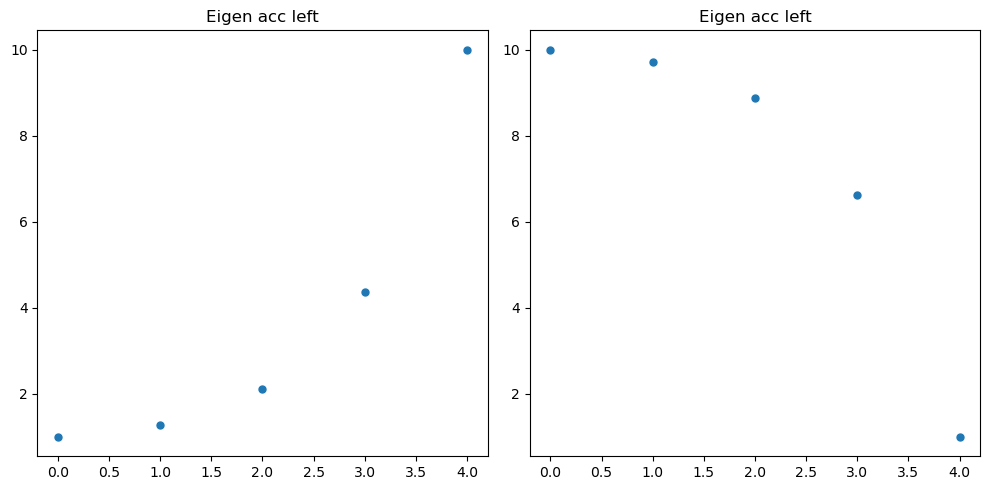

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_diagonal_matrix_acc_left(rho, lambda_1, N, lambda_N):
    """
    Generate a diagonal matrix A with the specified parameters.

    Parameters:
        rho (float): The parameter rho.
        lambda_1 (float): The parameter lambda_1.
        N (int): The size of the matrix.
        lambda_N (float): The parameter lambda_N.

    Returns:
        A (numpy.ndarray): The generated diagonal matrix.
    """
    # Initialize the diagonal matrix with zeros
    A = np.zeros((N, N))

    # Compute the diagonal elements according to the given formula
    for i in range(1, N+1):
        lambda_i = lambda_1 + ((i-1)/(N-1)) * (lambda_N - lambda_1) * rho**(N-i)
        A[i-1, i-1] = lambda_i

    return A

def generate_diagonal_matrix_acc_right(rho, lambda_1, N, lambda_N):
    """
    Generate a diagonal matrix A with the specified parameters.

    Parameters:
        rho (float): The parameter rho.
        lambda_1 (float): The parameter lambda_1.
        N (int): The size of the matrix.
        lambda_N (float): The parameter lambda_N.

    Returns:
        A (numpy.ndarray): The generated diagonal matrix.
    """
    # Initialize the diagonal matrix with zeros
    A = np.zeros((N, N))

    # Compute the diagonal elements according to the given formula
    for i in range(1, N+1):
        lambda_i = lambda_N - ((i-1)/(N-1)) * (lambda_N - lambda_1) * rho**(N-i)
        A[i-1, i-1] = lambda_i

    return A

# Example usage:
rho = .5
lambda_1 = 1.0
lambda_N = 10.0
N = 5
Al = generate_diagonal_matrix_acc_left(rho, lambda_1, N, lambda_N)
print("Generated diagonal matrix A acc in the left:")
print(Al)
Ar = generate_diagonal_matrix_acc_right(rho, lambda_1, N, lambda_N)
print("Generated diagonal matrix Aa acc in the right:")
print(Ar)
vector1=np.diag(Al)
vector2=np.diag(Ar)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first vector on the first subplot
axs[0].plot(vector1, marker='o', linestyle='', markersize=5, label='Vector 1')
axs[0].set_title('Eigen acc left')

# Plot the second vector on the second subplot
axs[1].plot(vector2, marker='o', linestyle='', markersize=5, label='Vector 2')
axs[1].set_title('Eigen acc left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Mathematical behavior of CG for diﬀerent eigenvalue distributions

Let $x_0$ be the initial guess and $r_0=b-Ax_0$, the CG method constructs a uniquely
determined approximation
$$
x_k\in x_0+\mathcal{K}_k(A,r_0) \text{ such that } r_k\perp\mathcal{K}_k(A,r_0)\qquad (1)
$$

Let $A=Q\Lambda Q^T$, with $\Lambda=\operatorname{diag}(\lambda_1,\dots,\lambda_N)$, and  $0<\lambda_1\leqslant\cdots\leqslant\lambda_N$, be an orthogonal diagonalization of the matrix $A$,  

We can represent the initial residual $r_0$ by its components in the
individual eigenvectors of $A$, stored in the columns of $Q$, as $r_0 = Q[\eta_1 ,\dots,\eta_N ]^T$. The
approximation $x_k\in x_0+\mathcal{K}_k(A,r_0)$ that is uniquely determined by the orthogonality
condition in (1) satisﬁes the (equivalent) optimality property
 <a name="eq2"></a>
$$
||x-x_k||_A=\min_{p\in P_k(0)}||p(A)(x-x_0)||_A=\min_{p\in P_k(0)}\begin{pmatrix}\displaystyle{\sum_{i=1}^N \eta_i^2\frac{p(\lambda_i)^2}{\lambda_i}}\end{pmatrix}^{1/2}\qquad (2)
$$
### Main point
*The CG optimality property (see (2)) **depends on the positions of the
individual eigenvalues**. Therefore **CG adapts without any a priori information
not only to the spectral interval, but in a signiﬁcant (and nonlinear) way also
to the distribution of the inner eigenvalues**. Acceleration of CG convergence is
more pronounced for matrices with **outlying eigenvalues**, and is diﬀerent when
the outliers are small or large.*

### Setup
We consider the behavior of CG in exact arithmetic for matrices having three
diﬀerent eigenvalue distributions. All matrices are diagonal with $N = 30$, $\lambda_1 = 0.1$, and $\lambda_N=10^3$. The ﬁrst matrix is a slight modiﬁcation of [(8)](#eq8), 
 <a name="eq3"></a>
$$
A=\operatorname{diag}(\lambda_1,\lambda_2,\dots,\lambda_{N-1},\lambda_{N}),\text{ with } \lambda_i=\lambda_N-\begin{pmatrix}\frac{i-1}{N-1}\end{pmatrix}(\lambda_N-\lambda_1)\rho^{N-i}\quad (3)
$$
for $i=2,\dots,N-1$, and $ \rho= 0.6$, so that the eigenvalues accumulate on the
right side of the spectrum. The second matrix is (8) with $ \rho= 0.6$, so that its eigenvalues
accumulate to the left side of the spectrum, and the third matrix is (8) with
$ \rho= 1$,
so that its eigenvalues are equally spaced. In all cases we use $b = [1, . . . , 1]^T/ \sqrt{N}$ , and
$x_0 = 0$. The function generate_diagonal_matrix_acc_right implements the [Equation (3)](#eq3). 

Iteration number of matrix A right: 5
Error  of matrix A right: [9.99623180e-01 9.98990038e-01 9.86436761e-01 4.13459725e-01
 5.58091313e-16]
Residual  of matrix A right: [5.52142624e-01 1.19699605e+00 6.22390731e+00 1.62363987e+01
 1.29953312e-14]
Iteration number of matrix A left: 5
Error  of matrix A left: [9.99259609e-01 9.98203833e-01 9.96609729e-01 9.93008316e-01
 2.16191561e-13]
Residual  of matrix A left: [1.08707687e+00 1.01546786e+00 9.38120653e-01 9.64416799e-01
 9.66970753e-12]
eigen left [1.00000e-01 5.40946e+01 1.80082e+02 4.50055e+02 1.00000e+03]
Iteration number of matrix A equi: 5
Error  of matrix A equi: [9.99500341e-01 9.99000833e-01 9.97837445e-01 9.90938271e-01
 1.03445432e-15]
Residual  of matrix A equi: [7.06965374e-01 8.35991100e-01 1.41016954e+00 3.68027963e+00
 4.09336685e-14]
eigen equal [1.00000e-01 2.50075e+02 5.00050e+02 7.50025e+02 1.00000e+03]


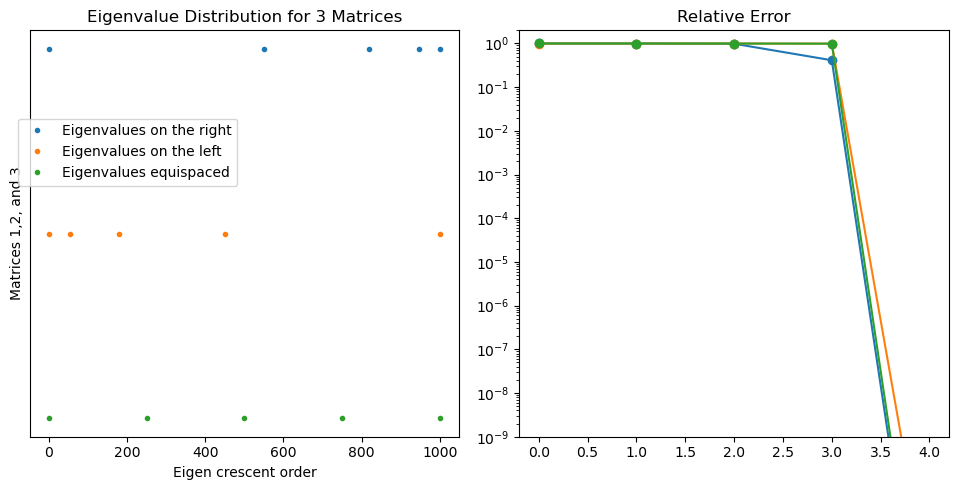

In [97]:
rho = .6
lambda_1 = 0.1
lambda_N = 10.0**3
N = 5
Ar = generate_diagonal_matrix_acc_right(rho, lambda_1, N, lambda_N)
vector1=np.diag(Ar)
b = np.ones_like(vector1)/np.sqrt(N)
x0 = np.zeros_like(b)
sol = np.linalg.solve(Ar,b)
appsol, num_iterations, relerrorvec1, relresvec1 = cg_cls(Ar, b, x0, sol)
print("Iteration number of matrix A right:", num_iterations)
print("Error  of matrix A right:", relerrorvec1)
print("Residual  of matrix A right:", relresvec1)

Al = generate_diagonal_matrix_acc_left(rho, lambda_1, N, lambda_N)
vector2=np.diag(Al)
b = np.ones_like(vector2)/np.sqrt(N)
x0 = np.zeros_like(b)
sol = np.linalg.solve(Al,b)
appsol, num_iterations, relerrorvec2, relresvec2 = cg_cls(Al, b, x0, sol)
print("Iteration number of matrix A left:", num_iterations)
print("Error  of matrix A left:", relerrorvec2)
print("Residual  of matrix A left:", relresvec2)
print('eigen left',vector2)

rho=1.
Am = generate_diagonal_matrix_acc_left(rho, lambda_1, N, lambda_N)
vector3=np.diag(Am)
sol = np.linalg.solve(Am,b)
appsol, num_iterations, relerrorvec3, relresvec3 = cg_cls(Am, b, x0, sol)
print("Iteration number of matrix A equi:", num_iterations)
print("Error  of matrix A equi:", relerrorvec3)
print("Residual  of matrix A equi:", relresvec3)
print('eigen equal',vector3)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first vector on the first subplot
y_values = np.ones_like(vector1)+2
axs[0].plot(vector1,y_values,marker='o', linestyle='', markersize=3,label='Eigenvalues on the right')
y_values = np.ones_like(vector2)+1
axs[0].plot(vector2,y_values,marker='o', linestyle='', markersize=3,label='Eigenvalues on the left')
y_values = np.ones_like(vector3)
axs[0].plot(vector3,y_values,marker='o', linestyle='', markersize=3,label='Eigenvalues equispaced')

axs[0].set_xlabel('Eigen crescent order')
axs[0].set_ylabel('Matrices 1,2, and 3')
axs[0].set_title('Eigenvalue Distribution for 3 Matrices')

# Add legend
axs[0].legend(loc='upper right', bbox_to_anchor=(.5, .8))
axs[0].set_yticks([])


# Plot the second vector on the second subplot
axs[1].plot(relerrorvec1,marker='o',label='Relative error right')
axs[1].plot(relerrorvec2, marker='o',label='Relative error left')
axs[1].plot(relerrorvec3,marker='o', label='Relative error left')

axs[1].set_title('Relative Error')
axs[1].set_yscale('log')
#axs[1].legend(loc='upper right', bbox_to_anchor=(.5, .8))
axs[1].set_ylim(10**(-9), 2)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()





## References

 - *Erin Carson, Jörg Liesen, Zdeněk Strakoš,* **Towards understanding CG and GMRES through
examples**,
 Linear Algebra and Its Applications, 2024 (https://doi.org/10.1016/j.laa.2024.04.003).  <a name="cls2024"></a>


